In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import os
import glob
import cvlib as cv
import glob
import os
import random
import numpy as np
import concurrent.futures
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_files = [f for f in glob.glob('/content/drive/MyDrive/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


### Tiền xử lí dữ liệu

In [ ]:
data = []
labels = []

def process_image(img, index):
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    # print(f"Processing image {index + 1}/{len(image_files)}\n")
    return image

def process_file(img):
    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
    return label

with concurrent.futures.ThreadPoolExecutor() as executor:
    image_results = [executor.submit(process_image, img, i) for i, img in enumerate(image_files)]
    label_results = [executor.submit(process_file, img) for img in image_files]
    for image_result, label_result in zip(image_results, label_results):
        image = image_result.result()
        label = label_result.result()
        data.append(image)
        labels.append([label])
print("Xong")

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

### Chia dữ liệu và encode nhãn

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

### biến đổi ảnh để tạo ra các biến thể mới 

In [ ]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


### Train model

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in vgg_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(aug.flow(trainX, trainY, batch_size=32),
                    validation_data=(testX, testY),
                    steps_per_epoch=len(trainX) // 32,
                    epochs=500, verbose=1)

### ĐỒ thị kết quả

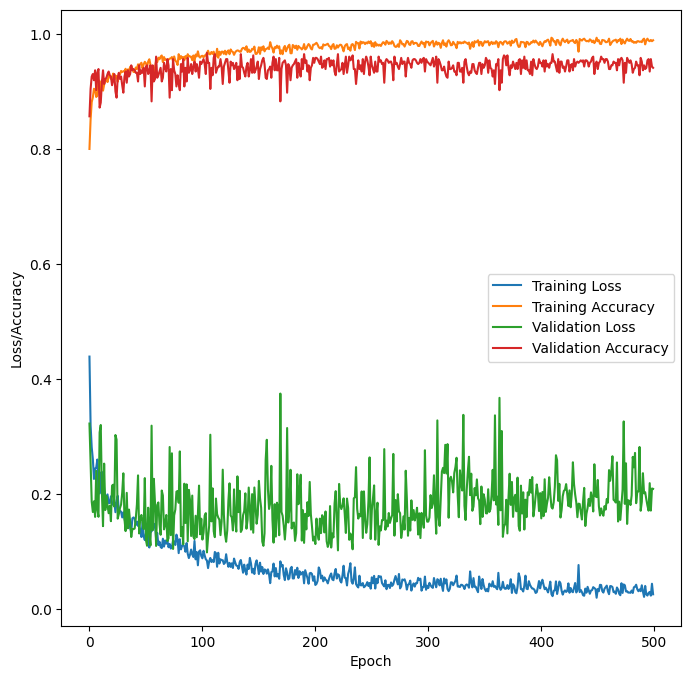

In [ ]:
import matplotlib.pyplot as plt
# Tạo một subplot có 1 hàng và 1 cột
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Vẽ biểu đồ loss và accuracy của đào tạo và đánh giá
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.legend()

plt.show()
